In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import os

import talib as ta

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [47]:

# 1. 读取数据
df = pd.read_csv('data/spot/binance/15m/BTC_USDT.csv')

# 选择时间范围
START_DATE = '2023-06-01'
END_DATE = '2025-06-30'
# 确保时间列为datetime类型
df['datetime'] = pd.to_datetime(df['datetime'])
data = df[(df['datetime'] >= START_DATE) & (df['datetime'] <= END_DATE)]
data.set_index('datetime', inplace=True)
data['ret'] = data['close'].pct_change()
data['ret1'] = data['close'].pct_change().shift(-2)

data.head()

C:\Users\hp\AppData\Local\Temp\ipykernel_10008\3005914116.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ret'] = data['close'].pct_change()
C:\Users\hp\AppData\Local\Temp\ipykernel_10008\3005914116.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ret1'] = data['close'].pct_change().shift(-2)


,open,high,low,close,volume,ret,ret1
datetime,,,,,,,
2023-06-01 00:00:00,27210.36,27350.00,27198.00,27318.11,843.33387,NaN,-0.006215
2023-06-01 00:15:00,27318.11,27338.80,27281.26,27281.27,447.97561,-0.001349,-0.001695
2023-06-01 00:30:00,27281.26,27297.20,27065.84,27111.73,932.19792,-0.006215,0.002240
2023-06-01 00:45:00,27111.73,27111.73,27023.35,27065.77,549.31703,-0.001695,0.000535
2023-06-01 01:00:00,27065.76,27145.52,27059.74,27126.40,380.74336,0.002240,-0.000832


In [48]:
missing = df.isnull().sum()
print("Missing values in total dataset:\n", missing)

Missing values in total dataset:
 datetime    0
open        0
high        0
low         0
close       0
volume      0
dtype: int64


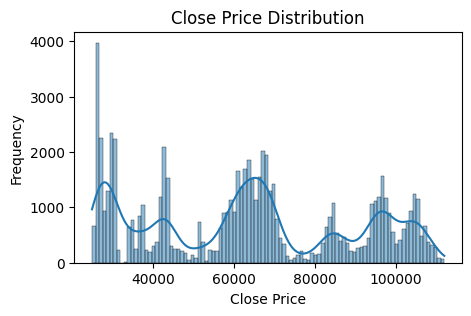

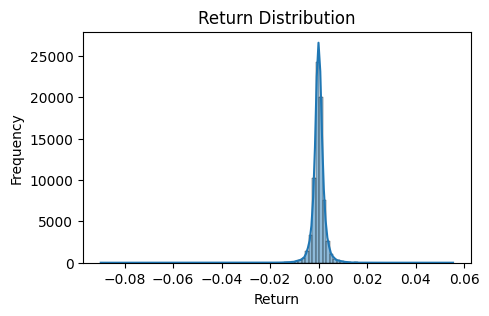

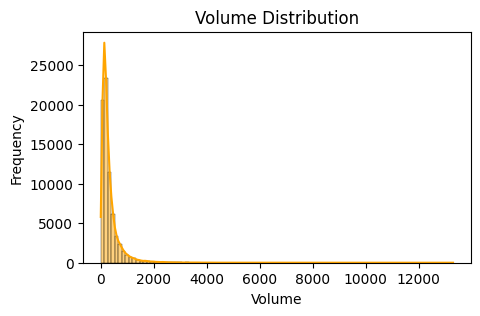

                open           high            low          close  \
count   72961.000000   72961.000000   72961.000000   72961.000000   
mean    63331.129743   63435.674913   63223.563573   63332.241442   
std     25915.526686   25961.765073   25868.985485   25915.720301   
min     24893.100000   24926.790000   24800.000000   24893.090000   
25%     40661.810000   40779.660000   40532.170000   40679.970000   
50%     63464.770000   63582.000000   63343.470000   63465.410000   
75%     85502.030000   85690.020000   85329.270000   85502.170000   
max    111898.740000  111980.000000  111681.810000  111898.740000   

             volume  
count  72961.000000  
mean     340.541351  
std      427.859641  
min        3.985380  
25%      126.941280  
50%      216.317980  
75%      391.761020  
max    13289.889260  


,open,high,low,close,volume,ret,ret1
count,72961.000000,72961.000000,72961.000000,72961.000000,72961.000000,72960.000000,72959.000000
mean,63331.129743,63435.674913,63223.563573,63332.241442,340.541351,0.000022,0.000022
std,25915.526686,25961.765073,25868.985485,25915.720301,427.859641,0.002599,0.002599
min,24893.100000,24926.790000,24800.000000,24893.090000,3.985380,-0.089797,-0.089797
25%,40661.810000,40779.660000,40532.170000,40679.970000,126.941280,-0.001064,-0.001064
50%,63464.770000,63582.000000,63343.470000,63465.410000,216.317980,0.000009,0.000009
75%,85502.030000,85690.020000,85329.270000,85502.170000,391.761020,0.001119,0.001119
max,111898.740000,111980.000000,111681.810000,111898.740000,13289.889260,0.055415,0.055415


In [49]:
# 2. 数据预处理，做一些初步的数据统计分布描述

# 绘制价格分布直方图
plt.figure(figsize=(5, 3))
sns.histplot(data['close'], bins=100, kde=True)
plt.title('Close Price Distribution')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.show()

# 绘制收益率分布直方图
plt.figure(figsize=(5, 3))
sns.histplot(data['ret'], bins=100, kde=True)
plt.title('Return Distribution')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.show()

# 绘制成交量分布直方图
plt.figure(figsize=(5, 3))
sns.histplot(data['volume'], bins=100, kde=True, color='orange')
plt.title('Volume Distribution')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.show()

# 计算并显示主要数值特征的描述性统计
print(data[['open', 'high', 'low', 'close', 'volume']].describe())
data.describe()


In [50]:
# 2. 特征工程（示例：用常见技术指标）
"""
技术指标列表
趋势: EMA (20, 60, 100, 200), MACD (12,26,9; 5,35,5), ADX (14)
动量: RSI (10, 20, 60), %K Stochastic (10, 30, 200)
反转: ROC(RSI) (10, 20, 50)
振幅: ATR (20, 60, 100), Bollinger Bands (20, 2)
成交量: OBV, VWAP
短期动态: MOM (10, 30, 50), PROC (10, 50)
"""

# 用talib计算特征，全部用talib函数

# 用talib计算特征，全部用talib函数
data['ema_20'] = ta.EMA(data['close'], timeperiod=20)
data['ema_60'] = ta.EMA(data['close'], timeperiod=60)
data['ema_100'] = ta.EMA(data['close'], timeperiod=100)
data['ema_200'] = ta.EMA(data['close'], timeperiod=200)

macd_20_60, macdsignal_20_60, macdhist_20_60 = ta.MACD(data['close'], fastperiod=20, slowperiod=60, signalperiod=9)
macd_10_20, macdsignal_10_20, macdhist_10_20 = ta.MACD(data['close'], fastperiod=10, slowperiod=20, signalperiod=5)
data['macd_20_60'] = macd_20_60
data['macd_10_20'] = macd_10_20

data['adx_10'] = ta.ADX(data['high'], data['low'], data['close'], timeperiod=10)
data['adx_20'] = ta.ADX(data['high'], data['low'], data['close'], timeperiod=20)
data['adx_60'] = ta.ADX(data['high'], data['low'], data['close'], timeperiod=60)

data['rsi_7'] = ta.RSI(data['close'], timeperiod=7)
data['rsi_20'] = ta.RSI(data['close'], timeperiod=20)
data['rsi_60'] = ta.RSI(data['close'], timeperiod=60)

slowk_10, slowd_10 = ta.STOCH(data['high'], data['low'], data['close'], fastk_period=10, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
slowk_30, slowd_30 = ta.STOCH(data['high'], data['low'], data['close'], fastk_period=30, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
slowk_100, slowd_100 = ta.STOCH(data['high'], data['low'], data['close'], fastk_period=100, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
data['stoch_k_10'] = slowk_10
data['stoch_k_30'] = slowk_30
data['stoch_k_100'] = slowk_100

data['roc_rsi_10'] = ta.ROC(data['rsi_7'], timeperiod=10)
data['roc_rsi_20'] = ta.ROC(data['rsi_7'], timeperiod=20)
data['roc_rsi_50'] = ta.ROC(data['rsi_7'], timeperiod=50)

data['atr_20'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=20)
data['atr_60'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=60)
data['atr_100'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=100)

# talib没有直接的Bollinger带宽和百分比，需手动计算
upper, middle, lower = ta.BBANDS(data['close'], timeperiod=30, nbdevup=2, nbdevdn=2, matype=0)
data['bb_width'] = upper - lower
data['bb_percent'] = (data['close'] - lower) / (upper - lower)

data['obv'] = ta.OBV(data['close'], data['volume'])

# VWAP简单实现
data['vwap'] = (data['volume'] * (data['high'] + data['low'] + data['close']) / 3).cumsum() / data['volume'].cumsum()

data['mom_5'] = ta.MOM(data['close'], timeperiod=5)
data['mom_20'] = ta.MOM(data['close'], timeperiod=20)
data['mom_50'] = ta.MOM(data['close'], timeperiod=50)

data['proc_5'] = ta.ROC(data['close'], timeperiod=5)
data['proc_20'] = ta.ROC(data['close'], timeperiod=20)

data['vol_ma_20'] = data['volume'].rolling(window=20).mean()
data['vol_ma_60'] = data['volume'].rolling(window=60).mean()

data.dropna(inplace=True)  # 删除含有NaN的行

C:\Users\hp\AppData\Local\Temp\ipykernel_10008\1919249095.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ema_20'] = ta.EMA(data['close'], timeperiod=20)
C:\Users\hp\AppData\Local\Temp\ipykernel_10008\1919249095.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ema_60'] = ta.EMA(data['close'], timeperiod=60)
C:\Users\hp\AppData\Local\Temp\ipykernel_10008\1919249095.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [51]:
data['signal'] = 0
data.loc[(data['ema_20'] > data['ema_60']) & (data['volume'] > data['vol_ma_20'] * 2), 'signal'] = 1
data.loc[(data['ema_20'] < data['ema_60']) & (data['volume'] > data['vol_ma_20'] * 2), 'signal'] = -1
data['signal'] = data['signal'].replace(to_replace=0, method='ffill').fillna(0)

# data.loc[data['volume'] < data['vol_ma_20'] * 0.8, 'signal'] = 0

C:\Users\hp\AppData\Local\Temp\ipykernel_10008\2001770217.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['signal'] = 0
C:\Users\hp\AppData\Local\Temp\ipykernel_10008\2001770217.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['signal'] = data['signal'].replace(to_replace=0, method='ffill').fillna(0)


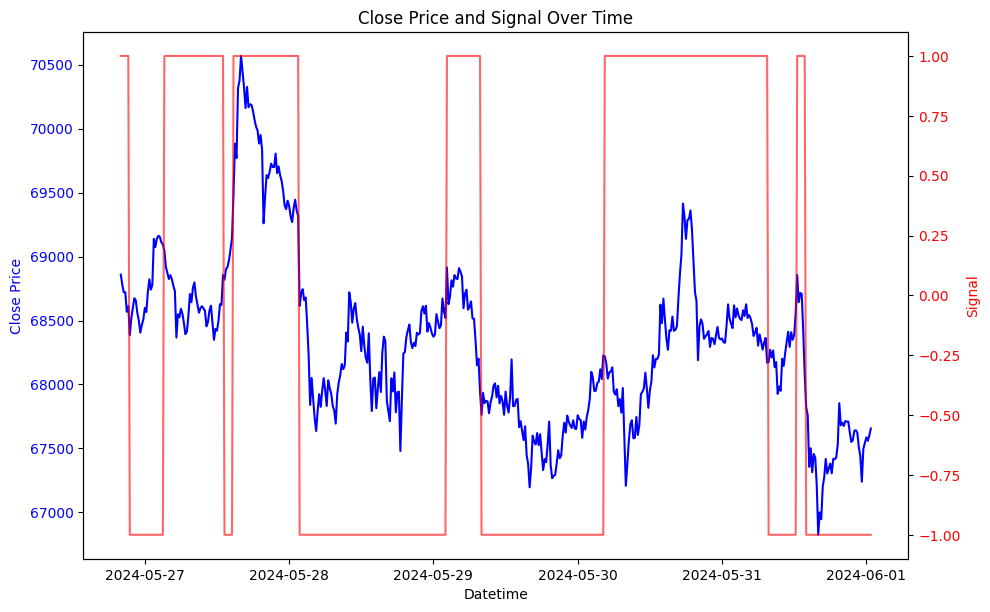

Correlation between Signal and Return: -0.0644


In [52]:
# 按照固定样本量，随机选取开始时间
sample_size = 500  # 固定样本量
start_idx = np.random.randint(0, len(data) - sample_size)  # 随机选取开始索引
selected_data = data.iloc[start_idx:start_idx + sample_size]

# 绘制 signal 和 close 的组合图
fig, ax1 = plt.subplots(figsize=(10, 6))

# 绘制 close 曲线
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Close Price', color='blue')
ax1.plot(selected_data.index, selected_data['close'], color='blue', label='Close Price')
ax1.tick_params(axis='y', labelcolor='blue')

# 创建第二个坐标轴，绘制 signal 曲线
ax2 = ax1.twinx()
ax2.set_ylabel('Signal', color='red')
ax2.plot(selected_data.index, selected_data['signal'], color='red', label='Signal', alpha=0.6)
ax2.tick_params(axis='y', labelcolor='red')

# 添加图例
fig.tight_layout()
plt.title('Close Price and Signal Over Time')
plt.show()

# 评估 signal 和收益率的相关性
correlation = selected_data['signal'].corr(selected_data['ret1'])
print(f"Correlation between Signal and Return: {correlation:.4f}") 

<Axes: xlabel='datetime'>

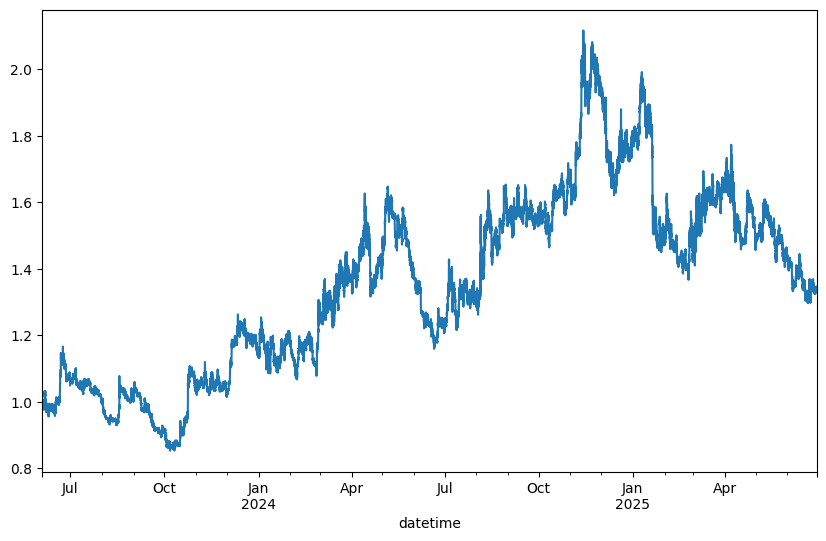

In [53]:
(1+data['ret1']*data['signal']).cumprod().plot(figsize=(10, 6))

In [54]:
# 统计 signal 为 1 时，ret1 > 0 的比例
signal_1_correct = (data.loc[data['signal'] == 1, 'ret1'] > 0).mean()

# 统计 signal 为 -1 时，ret1 < 0 的比例
signal_neg1_correct = (data.loc[data['signal'] == -1, 'ret1'] < 0).mean()

# 计算总体准确率
total_accuracy = (signal_1_correct + signal_neg1_correct) / 2

print(f"Accuracy when signal is 1: {signal_1_correct:.2%}")
print(f"Accuracy when signal is -1: {signal_neg1_correct:.2%}")
print(f"Overall accuracy: {total_accuracy:.2%}")

Accuracy when signal is 1: 49.89%
Accuracy when signal is -1: 49.36%
Overall accuracy: 49.63%
